In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Please read train/test with auxiliary data
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

## Add Auxiliary datasetI(time consuming, already provided in the Directory)
1km MRT, 
2km primary school 
500m hawker 
3km cc/shopping mall
Only primary school entrance also depends on locations of home(condo), secondary school depends on test


## Please read train/test data equiped with auxility data

In [3]:
train_df = pd.read_csv('./train_add_aux.csv',index_col=0)
test_df = pd.read_csv('./test_add_aux.csv',index_col=0)

In [4]:
## Data overview
print("train.describle:",'\n',train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048 entries, 0 to 26047
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   listing_id                  26048 non-null  int64  
 1   name                        26048 non-null  object 
 2   street                      26048 non-null  object 
 3   type                        26048 non-null  object 
 4   model                       24768 non-null  object 
 5   market_segment              26048 non-null  object 
 6   type_of_area                26048 non-null  object 
 7   bedrooms                    25644 non-null  object 
 8   bathrooms                   24812 non-null  float64
 9   district                    26048 non-null  int64  
 10  region                      26048 non-null  object 
 11  planning_area               26048 non-null  object 
 12  subszone                    26048 non-null  object 
 13  lat                         260

**OVERALL**

Train featrues:
- **Nominal**: listing_id, name, street, type, model, market_segment, type_of area, district, region, planning, area, subszone, eco_category, accessibility
- **Ratio**: bedrroms, bathrooms, lat, lng, no_of_units, area_size
- **Ordinal**: tenure, built year, data_list

Goal features:
- **Ratio**: price

## Goals
/ Delete irrelative attributes
/ Process the missing values
/ Encoding the text features
/ Identify and process dirty data (including outliers)
/ Find out the most important features

## Challenges
- Too many missing values in 'built_year', delete the attribute or imputation?
- Too many discretive values in 'name', 'street', 'type',..., how to process?
- How to bucket features?

# Exploratory Data Analysis & Preprocessing.

## Identify and process missing values

In [5]:
train_df.isna().sum()

listing_id                        0
name                              0
street                            0
type                              0
model                          1280
market_segment                    0
type_of_area                      0
bedrooms                        404
bathrooms                      1236
district                          0
region                            0
planning_area                     0
subszone                          0
lat                               0
lng                               0
tenure                          287
built_year                    10043
no_of_units                    1042
area_size                         2
eco_category                      0
accessibility                     0
date_listed                       0
price                             0
no_of_nearest_famous_pshcl        0
no_of_nearest_commerical          0
no_of_nearest_gov                 0
no_of_nearest_train               0
no_of_nearest_shopping      

In [6]:
##　Identify missing values
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

train_missing = train_df.isnull().sum()
train_missing = train_missing[train_missing>0] # cols with # of missing vals
train_missing.sort_values(inplace=True)
test_missing = test_df.isnull().sum()
test_missing = test_missing[test_missing>0] # cols with # of missing vals
test_missing.sort_values(inplace=True)

print('Columns including missing value in train data:','\n',list(train_missing.index))
print()
print('Columns including missing value in test data:','\n', list(test_missing.index))
missing_idx=train_missing.index

Columns including missing value in train data: 
 ['area_size', 'tenure', 'bedrooms', 'no_of_units', 'bathrooms', 'model', 'built_year']

Columns including missing value in test data: 
 ['tenure', 'bedrooms', 'no_of_units', 'bathrooms', 'model', 'built_year']


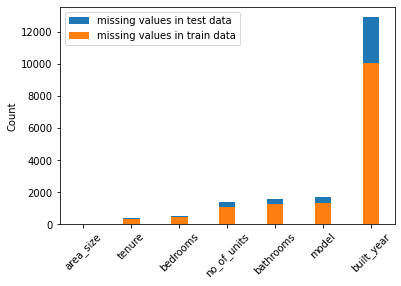

In [7]:
# No. of each col's missing vals
train_m = []
test_m= []

for idx in missing_idx:
    try:
        train_m.append(train_missing[idx])
        test_m.append(test_missing[idx])
    except:
        test_m.append(0)

## Start to plot
ind = np.arange(len(train_m))
width=0.35

p1 = plt.bar(ind, test_m, width,bottom=train_m)
p2 = plt.bar(ind, train_m, width)

plt.ylabel('Count')
plt.xticks(ind,missing_idx,rotation=45 )

plt.legend((p1[0], p2[0]), ('missing values in test data', 'missing values in train data'))
plt.show()

Many missing values in column "built_year", which may affect the sale price (people tend to buy newly_built condos), 

How to solve this problem? Delete the attribute? Imputation?

Before fillNA, we need group some feature to fill others, like `street`. 

Process `street` -> street without out number

In [8]:
# 提前使用，提取【street without number】
def street_strip(x):
    return x.strip()
    
train_df['street'] = train_df['street'].apply(lambda x: street_strip(x))
test_df['street'] = test_df['street'].apply(lambda x: street_strip(x))

def norm_street_name(x):
    temp = x.split(" ")
    if temp[0].isdigit():
        return ' '.join(temp[1:])
    else:
        return x
    
train_df['street_name'] = train_df['street'].apply(lambda x: norm_street_name(x))
test_df['street_name'] = test_df['street'].apply(lambda x: norm_street_name(x))

### Fillna: Forward Fill

In [9]:
id_list = ['name','street_name','type', 'model','district','region','planning_area','subszone']

# 放宽
less_id_list = ['name','street_name', 'type','district']

def col_no_na(df_or_seires):
    return f'number of missing values:{df_or_seires.isna().sum()}'

如果没有明显依赖于某些参数 或者互相依赖，那从缺失少的开始？

`area_size`, 2 NA：can be infer from same `condo name` or `street name`

strong correlated with bedrooms, bathrooms (living room) 

In [10]:
print(col_no_na(train_df.area_size))

add_limit = ['bedrooms','bathrooms']
train_df['area_size'] = train_df['area_size'].fillna(train_df.groupby(less_id_list)['area_size'].transform('mean'))
test_df['area_size'] = test_df['area_size'].fillna(test_df.groupby(less_id_list)['area_size'].transform('mean'))


print(col_no_na(train_df.area_size))

number of missing values:2
number of missing values:0


`bedrooms`, 404 NA：first `area_size`, then rest, `condo name`

In [11]:
# add_limit=['built_year','area_size']

# 不用built year 因为还会有大量missing val
add_limit=['area_size']

print(col_no_na(train_df['bedrooms']))

train_df['bedrooms'] = train_df.groupby(add_limit)['bedrooms'].ffill()
# train_df['bedrooms'] = train_df['bedrooms'].fillna(train_df.groupby(identy_list)['bedrooms'].transform('max'))
train_df['bedrooms'] = train_df.groupby('name')['bedrooms'].ffill()

test_df['bedrooms'] = test_df.groupby(add_limit)['bedrooms'].ffill()
test_df['bedrooms'] = test_df.groupby('name')['bedrooms'].ffill()


print(col_no_na(train_df['bedrooms']))

number of missing values:404
number of missing values:7


`bathrooms`, 1236 NA：first `area_size`, then rest, `condo name`

In [12]:
print(col_no_na(train_df.bathrooms))

#train_df['bathrooms'] = train_df['bathrooms'].fillna(train_df.groupby('area_size')['bathrooms'].transform('mean'))
train_df['bathrooms'] = train_df.groupby('area_size')['bathrooms'].ffill()
train_df['bathrooms'] = train_df.groupby('name')['bathrooms'].ffill()

test_df['bathrooms'] = test_df.groupby('area_size')['bathrooms'].ffill()
test_df['bathrooms'] = test_df.groupby('name')['bathrooms'].ffill()

print(col_no_na(train_df.bathrooms))

number of missing values:1236
number of missing values:13


`tenure`, 287 NA: shared by the same`condo name`; then consider `street name`

In [13]:
print(col_no_na(train_df.tenure))

train_df['tenure'] = train_df.groupby("name")['tenure'].ffill()
print(col_no_na(train_df.tenure))
train_df['tenure'] = train_df.groupby("street_name")['tenure'].ffill()

test_df['tenure'] = test_df.groupby("name")['tenure'].ffill()
test_df['tenure'] = test_df.groupby("street_name")['tenure'].ffill()

print(col_no_na(train_df.tenure))

number of missing values:287
number of missing values:123
number of missing values:29


`no_of_units`, 1042 NA: ffill by the mean of `condo name`；the rest, ffill by the mean of same `street_name`
by group's mean

In [14]:
# use mean
print(col_no_na(train_df.no_of_units))
train_df['no_of_units'] = train_df['no_of_units']\
    .fillna(train_df.groupby(["name"])['no_of_units'].transform('mean'))

print(col_no_na(train_df.no_of_units))
# 存在整个小区 name 都没有no_of_units, 
# 放松条件：那从【精确的有No的street上面】临近找相似 KNN
train_df['no_of_units'] = train_df['no_of_units']\
    .fillna(train_df.groupby(["street"])['no_of_units'].transform('mean'))

print(col_no_na(train_df.no_of_units))
# 放松条件：那从【粗略的street上面】临近截取
train_df['no_of_units'] = train_df['no_of_units']\
    .fillna(train_df.groupby(["street_name"])['no_of_units'].transform('mean'))
print(col_no_na(train_df.no_of_units))

test_df['no_of_units'] = test_df['no_of_units']\
    .fillna(train_df.groupby(["name"])['no_of_units'].transform('mean'))
test_df['no_of_units'] = test_df['no_of_units']\
    .fillna(train_df.groupby(["street"])['no_of_units'].transform('mean'))
test_df['no_of_units'] = test_df['no_of_units']\
    .fillna(train_df.groupby(["street_name"])['no_of_units'].transform('mean'))


# 还残留一些

number of missing values:1042
number of missing values:1015
number of missing values:503
number of missing values:224


In [15]:
train_df.isna().sum()

listing_id                        0
name                              0
street                            0
type                              0
model                          1280
market_segment                    0
type_of_area                      0
bedrooms                          7
bathrooms                        13
district                          0
region                            0
planning_area                     0
subszone                          0
lat                               0
lng                               0
tenure                           29
built_year                    10043
no_of_units                     224
area_size                         0
eco_category                      0
accessibility                     0
date_listed                       0
price                             0
no_of_nearest_famous_pshcl        0
no_of_nearest_commerical          0
no_of_nearest_gov                 0
no_of_nearest_train               0
no_of_nearest_shopping      

`built_year`, 10043 NA: same as `condo name`; for the rest, ffill by `street name`

In [16]:

print(col_no_na(train_df.built_year))

# list(train_df.groupby(id_list)['built_year'])

# train_df['built_year'] = train_df.groupby(id_list)['built_year'].ffill()

# use less feature
train_df['built_year'] = train_df.groupby("name")['built_year'].ffill()
print(col_no_na(train_df.built_year))

train_df['built_year'] = train_df.groupby("street")['built_year'].ffill()


test_df['built_year'] = test_df.groupby("name")['built_year'].ffill()
test_df['built_year'] = test_df.groupby("street")['built_year'].ffill()

print(col_no_na(train_df.built_year))

number of missing values:10043
number of missing values:4353
number of missing values:2728


<font color='red'>Still have missing data</font>

## Identify and process dirty data

`bedrooms`

Feature `bedrooms` is a string type feature having data like: `3+1`,`2`,`10+`,`(NAN)`. As in Singapore `3+1` means three bedrooms with one livingroom. Thus we try to split it into three features: `only_bedrooms`, `bedrooms`(sum of original `bedrooms` feature) and `livingrooms`.

In [17]:
from math import isnan
# convert str to numeric data
def split_bedroom_create_livingrooms(x):
    if type(x) == float:          # for NAN data
        return np.nan
    elif '+' in x:
        if x.split("+")[1] == '': # for case '10+' a missing 2,
            return 2
        else:
            return int(x.split("+")[1])
    else:                         # for case '3' (no living rooms)
        return 0
    
def true_bedrooms(x):
    if type(x) == float:
        return np.nan
    else:
        return int(x.split("+")[0])
    
train_df['livingrooms'] = train_df['bedrooms'].apply(lambda x:split_bedroom_create_livingrooms(x))
train_df['only_bedrooms'] = train_df['bedrooms'].apply(lambda x:true_bedrooms(x))


test_df['livingrooms'] = test_df['bedrooms'].apply(lambda x:split_bedroom_create_livingrooms(x))
test_df['only_bedrooms'] = test_df['bedrooms'].apply(lambda x:true_bedrooms(x))

In [18]:
print('Is there any duplicates in the training dataset:\n',any(train_df.duplicated()))

Is there any duplicates in the training dataset:
 False


`tenure` -> `tenure_yr`, extract years, not bucketing

In [19]:
train_df['tenure'].value_counts()

leasehold/99 years            15455
freehold                       9938
999 years                       440
leasehold/103 years              73
956 years from 27/05/1928        15
leasehold/60 years               15
110 years from 01/11/2017         8
946 years from 01/01/1938         8
99 years                          6
99 years from 14/08/2018          5
929 years from 01/01/1953         5
99 years from 03/07/2019          3
998 years from 12/10/1885         3
947 years from 15/05/1937         2
100 years from 01/02/1986         2
946 years from 27/11/1937         2
99 years from 24/12/2018          2
99 years from 01/12/1991          2
99 years from 01/12/1994          1
99 years from 04/06/2012          1
99 years from 03/08/2010          1
99 years from 01/12/1997          1
99 years from 12/08/1996          1
99 years from 02/02/1998          1
99 years from 11/07/2011          1
99 years from 15/06/2011          1
99 years from 10/01/2011          1
99 years from 03/10/2011    

In [20]:
# ## Process attribute tenure
# ##　bucketing
# import re

# reg = '[0-9]+ '
# def process_tenure(data_tenure):
#     tenure_label = []
#     for i in data_tenure:
# #     for i in train_df['tenure']:
#         try:
#     #         results = ' 99 ' in ' '+i or '/99' in ' ' + i
#             if i == 'freehold':
#                 tenure_label.append(2)
#                 #tenure_label.append('>9999')
#                 continue
#             results = int(re.findall(reg, ' '+ i)[0])
#             tenure_label.append(int(results > 500))
#             #tenure_label.append(int(results))
#         except:
#             tenure_label.append(i)
#     return tenure_label 

    
# ## ! Process attribute tenure, into number
import re
def extract_tenure_yrs(col):
    reg = '[0-9]+ '
    tenure_label = []
    for i in col:
        try:
            if i == 'freehold': # freehold = 10k years
                tenure_label.append(10000)
                continue
            
            # else，regEx for extract years
            results = int(re.findall(reg, ' '+ i)[0])
            if results == 9999: # as a outlier
                results = 999
            tenure_label.append(results)
            #tenure_label.append(int(results))
        except:
            # nan
            tenure_label.append(i)
    return tenure_label

In [21]:
tenure_label = extract_tenure_yrs(train_df['tenure'])
train_df['tenure']=tenure_label
# print("train:\n",train_df['tenure'].value_counts())

tenure_label = extract_tenure_yrs(test_df['tenure'])
test_df['tenure']=tenure_label

# print("test:\n",train_df['tenure'].value_counts())

In [22]:
train_df.isna().sum()

listing_id                       0
name                             0
street                           0
type                             0
model                         1280
market_segment                   0
type_of_area                     0
bedrooms                         7
bathrooms                       13
district                         0
region                           0
planning_area                    0
subszone                         0
lat                              0
lng                              0
tenure                          29
built_year                    2728
no_of_units                    224
area_size                        0
eco_category                     0
accessibility                    0
date_listed                      0
price                            0
no_of_nearest_famous_pshcl       0
no_of_nearest_commerical         0
no_of_nearest_gov                0
no_of_nearest_train              0
no_of_nearest_shopping           0
no_of_nearest_primar

scale `Price`
scal price unit to million.

In [23]:
train_df['price']=train_df['price']/1000000

`Date_listed`: into bucket

In [24]:
def bucket_date_listed(x):
    if x<'2020-12-01':
        return 0
    elif x<'2021-03-01':
        return 1
    elif x < '2021-06-01':
        return 2
    elif x < '2021-09-01':
        return 3
    elif x < '2021-12-01':
        return 4
    elif x<'2022-03-01':
        return 5
    else:
        return 6

# train_df['date_listed'] = train_df['date_listed'].apply(lambda x: bucket_date_listed(x.replace("/", '-')))
train_df['date_listed'] = train_df['date_listed'].apply(lambda x: bucket_date_listed(x))

test_df['date_listed'] = test_df['date_listed'].apply(lambda x: bucket_date_listed(x))

train_df['date_listed'].value_counts()

5    15820
4     8186
3     1065
2      788
1      187
0        2
Name: date_listed, dtype: int64

`type` and `model`: feature engineering to combine

In [25]:
print("Mean price(million) group in Type:\n",train_df.groupby(['type'])['price'].mean())
print("="*30)
print()
print("Mean price(million) group in Model:\n",train_df.groupby(['model'])['price'].mean())

Mean price(million) group in Type:
 type
apartment      2.925477
condominium    3.074552
Name: price, dtype: float64

Mean price(million) group in Model:
 model
apartment                                  2.941825
condominium                                3.164081
duplex                                     4.234550
executive condominium                      1.401398
high rise                                  2.359133
low rise                                   1.707067
penthouse                                  8.389150
residential with commercial on level 1     9.460000
shophouse                                 11.880000
soho                                       0.867800
strata terrace                             2.601500
townhouse                                  3.867270
walk-up apt                                1.981437
with pool                                  1.546160
Name: price, dtype: float64


The average prices of the two type of buildings are not much different. Some type-model combinations like *'apartment-soho'* is rarely appeared.

<font color='red'>Two ways:</font>
1. Drop 'model' feature, only keep using 'type' **OR** drop 'type' only keep 'model' feature.
2. Merge two features into one feature 'type-model' and drop some category with small value counts. Keep:'ap-ap','condo-condo','condo-excondo','ap-walk','condo-th','apt-condo'.

In [26]:
# here implement in the second way
keep_model_type = ['condominium_condominium','apartment_apartment',
                   'condominium_executive condominium',
                   'apartment_walk-up apt','apartment_condominium',
                   'condominium_townhouse']

def model_type(x):
    if x in keep_model_type:
        return x
    else:
        type_ = x.split('_')[0]
        return type_ +'_' + type_

train_df.model.fillna('None',inplace=True)
train_df['model_type'] = train_df['type'] + "_" + train_df['model']
train_df['model_type'] = train_df['model_type'].apply(lambda x:model_type(x))

test_df.model.fillna('None',inplace=True)
test_df['model_type'] = test_df['type'] + "_" + test_df['model']
test_df['model_type'] = test_df['model_type'].apply(lambda x:model_type(x))

train_df.head()

,listing_id,name,street,type,model,market_segment,type_of_area,bedrooms,bathrooms,district,...,no_of_nearest_commerical,no_of_nearest_gov,no_of_nearest_train,no_of_nearest_shopping,no_of_nearest_primary,no_of_nearest_secondary,street_name,livingrooms,only_bedrooms,model_type
0,6998418,seascape,57 cove way,condominium,condominium,ocr,strata,3,4.0,4,...,0,0,0,0,0,0,cove way,0.0,3.0,condominium_condominium
1,2046604,la maison,10 moulmein rise,apartment,apartment,ocr,strata,3,3.0,11,...,3,0,1,47,6,10,moulmein rise,0.0,3.0,apartment_apartment
2,7563513,viva,2 suffolk walk,condominium,condominium,ocr,strata,4,3.0,11,...,3,0,2,52,6,7,suffolk walk,0.0,4.0,condominium_condominium
3,3071445,urban treasures,205 jalan eunos,condominium,condominium,ocr,strata,3,2.0,14,...,1,0,2,14,3,9,jalan eunos,0.0,3.0,condominium_condominium
4,9667539,infini at east coast,east coast road,apartment,apartment,ocr,strata,3,3.0,15,...,1,0,0,15,6,10,east coast road,0.0,3.0,apartment_apartment


## Drop features

### with th ONLY unique value

In [27]:
unique_value = train_df.nunique()
unique_value.T

listing_id                    26048
name                           1650
street                         3431
type                              2
model                            15
market_segment                    1
type_of_area                      1
bedrooms                         17
bathrooms                         9
district                         27
region                            5
planning_area                    38
subszone                        193
lat                            3118
lng                            3118
tenure                           12
built_year                       60
no_of_units                     601
area_size                      1180
eco_category                      1
accessibility                     1
date_listed                       6
price                          4704
no_of_nearest_famous_pshcl        4
no_of_nearest_commerical          8
no_of_nearest_gov                 6
no_of_nearest_train              11
no_of_nearest_shopping      

In [28]:
train_df = train_df.drop(['listing_id','market_segment','type_of_area','eco_category','accessibility'],axis=1)
test_df = test_df.drop(['listing_id','market_segment','type_of_area','eco_category','accessibility'],axis=1)

### drop old feature where there are new one

In [29]:
train_df.shape

(26048, 29)

## Split into x_train, y_train and x_test_origin

In [30]:

drop_list = ['street','model','type','bedrooms']
#drop_list = ['street','model','type']
target = ['price']

# train_df = train_df.dropna()
# print("length of training data",len(train_df))

# Get dataset
train_df = train_df.drop(drop_list,axis=1)
test_df = test_df.drop(drop_list,axis=1)

y_train = train_df[target]
x_train = train_df.drop(target,axis=1)
x_test_origin = test_df

# x_train.head()

In [31]:
x_train.shape, x_test_origin.shape

((26048, 24), (7500, 24))

In [41]:
# intermediate result file, to local
x_train.to_csv("input_train_features_before_EncNorm.csv", index=False)
y_train.to_csv("model_input_train_prices.csv", index=False)

x_test_origin.to_csv("input_test_before_EncNorm.csv", index=False);

# Data visualization

delete attributes listing_id，market_segment, type_of_area, eco_category, accessibility?
字符型特征离散化，离散型特征分桶


In [32]:
# Identify the qualitative variables and quantitative variables

quantitative = [f for f in x_train.columns if train_df.dtypes[f] != 'object']
quantitative.remove('district')
quantitative.remove('tenure')

qualitative = list(set(x_train.columns)-set(quantitative))
qualitative

['subszone',
 'street_name',
 'tenure',
 'model_type',
 'planning_area',
 'region',
 'name',
 'district']

### Distribution of quantitative features

/Users/kenny/opt/anaconda3/envs/mlds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kenny/opt/anaconda3/envs/mlds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kenny/opt/anaconda3/envs/mlds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

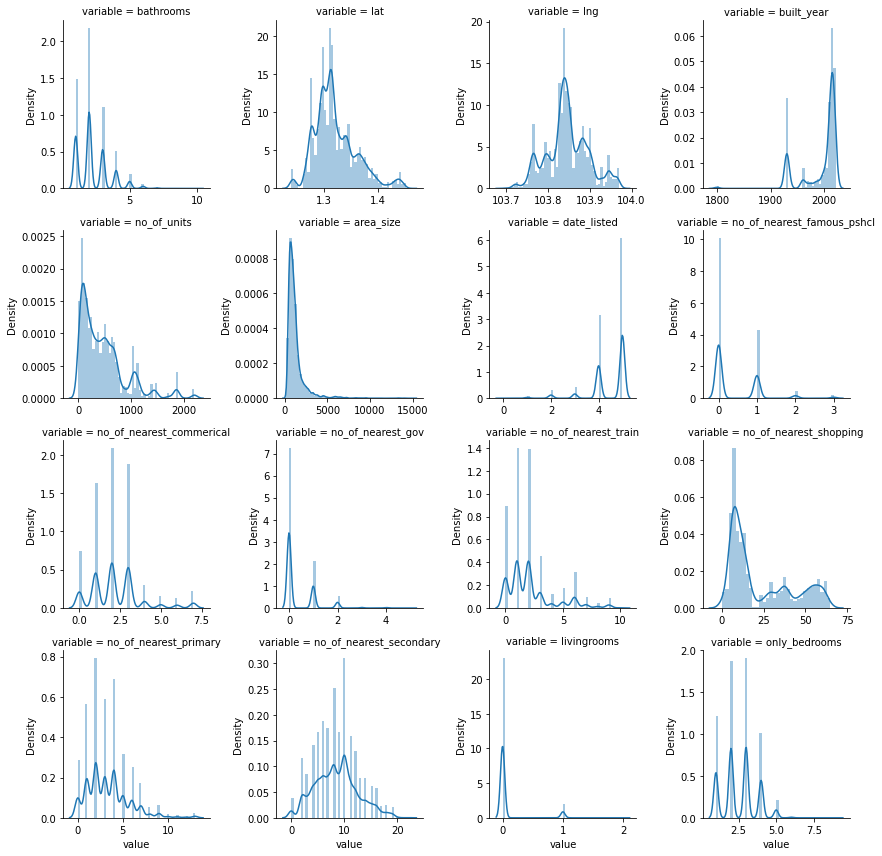

In [33]:
quan_data = pd.melt(train_df,value_vars=quantitative)   
dis_quan = sns.FacetGrid(quan_data, col="variable",  col_wrap=4, sharex=False, sharey=False)
dis_quan.map(sns.distplot, "value")

### Relationship between quantitative features and output

/Users/kenny/opt/anaconda3/envs/mlds/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


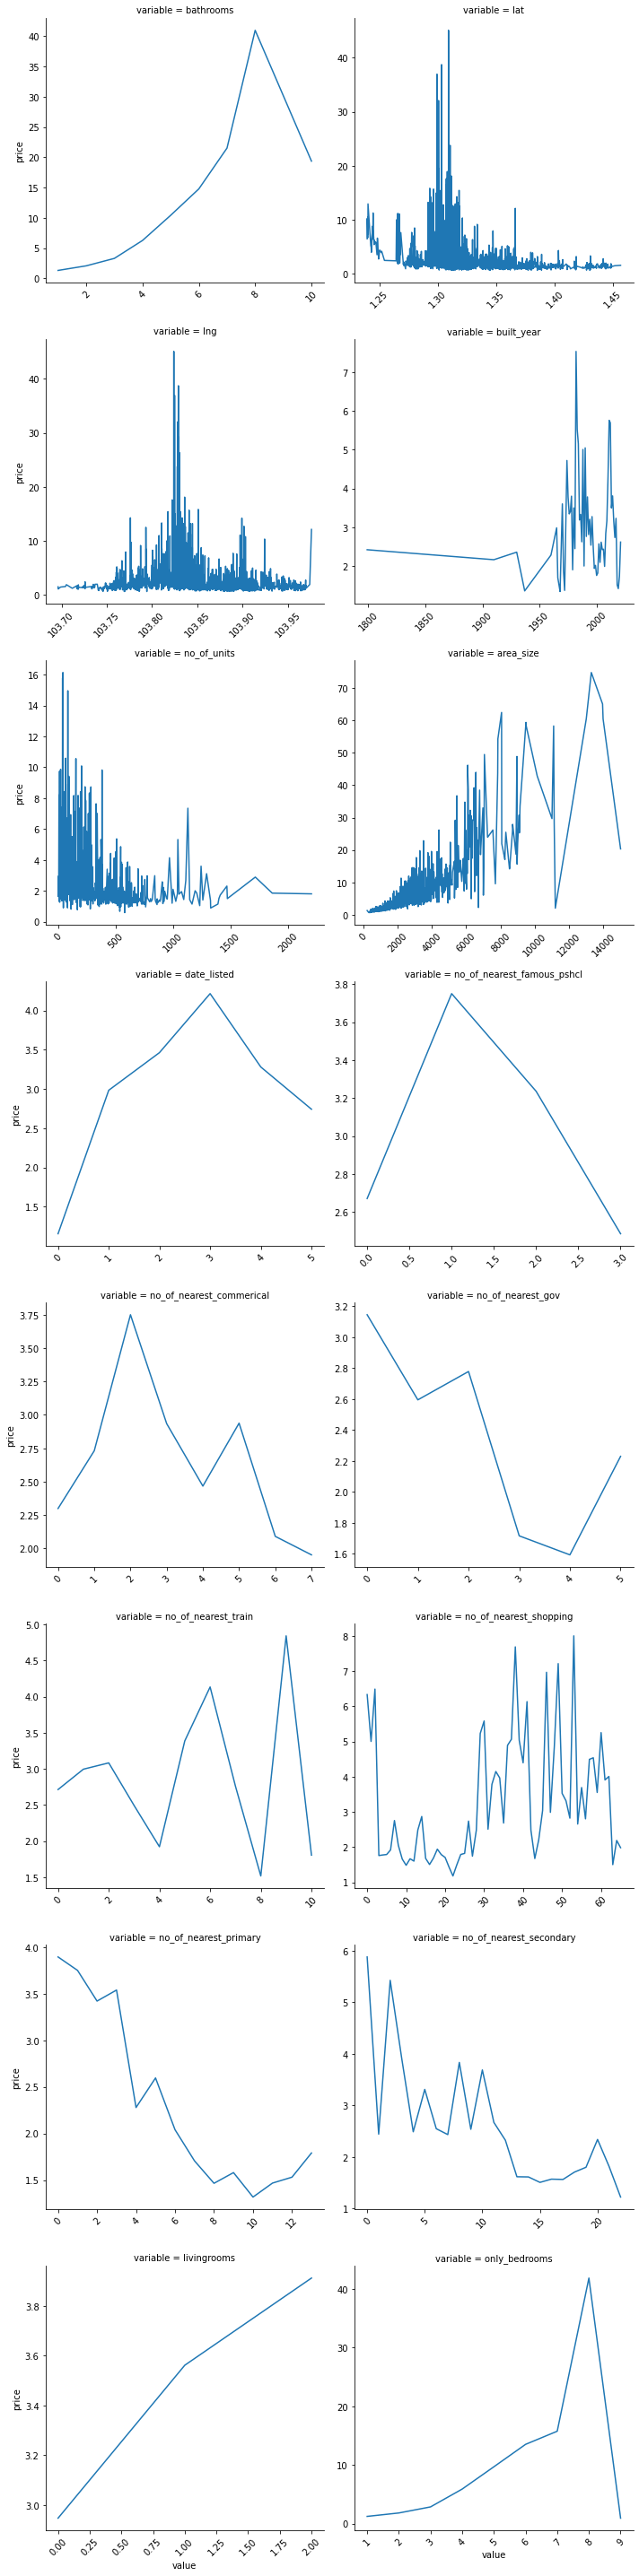

In [34]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'val': x, 'price': y})
    ts = ts.groupby('val').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=45)

quan_data_y = pd.melt(train_df,id_vars='price',value_vars=quantitative)
rel_quan = sns.FacetGrid(quan_data_y, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
rel_quan.map(pairplot, "value", "price")

### Correlations between quantitative features

                            bathrooms       lat       lng  built_year  \
bathrooms                    1.000000 -0.086087 -0.019662    0.001760   
lat                         -0.086087  1.000000  0.136575    0.015392   
lng                         -0.019662  0.136575  1.000000    0.210244   
built_year                   0.001760  0.015392  0.210244    1.000000   
no_of_units                 -0.045831  0.041640 -0.020600   -0.256208   
area_size                    0.719626 -0.191104 -0.044939    0.095927   
date_listed                 -0.026892  0.052815 -0.014869   -0.293984   
no_of_nearest_famous_pshcl   0.056475 -0.021769 -0.224418   -0.169968   
no_of_nearest_commerical    -0.052005 -0.200031 -0.077702   -0.123366   
no_of_nearest_gov           -0.116026 -0.227740  0.040849    0.051699   
no_of_nearest_train         -0.056989 -0.141302  0.020172    0.110454   
no_of_nearest_shopping       0.028394 -0.403518 -0.036273    0.064331   
no_of_nearest_primary       -0.061699  0.575351  0.

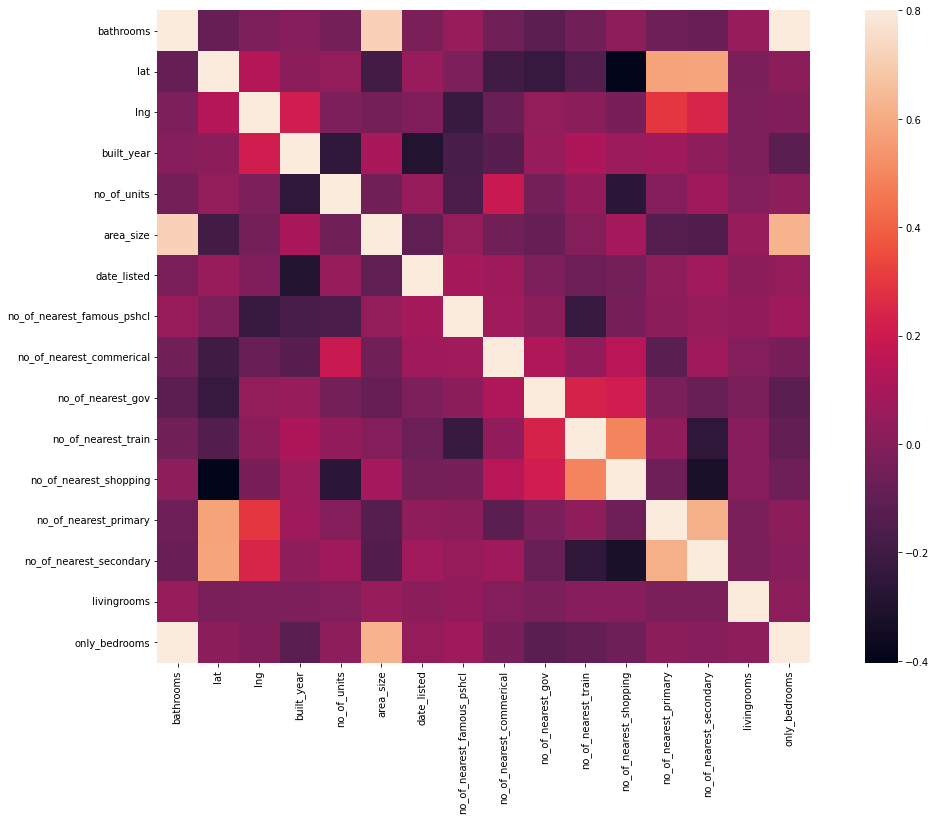

In [35]:
train_corr = x_train[quantitative].corr()
print(train_corr)
a = plt.subplots(figsize = (20,12))
a=sns.heatmap(train_corr,vmax=.8,square=True)
a.set_yticklabels(a.get_yticklabels(), rotation=360)
a.set_xticklabels(train_corr.index, rotation='vertical')
plt.show()

High correlation with area_size and bathrooms, bedrooms

### Relationship between qualitative feature and output

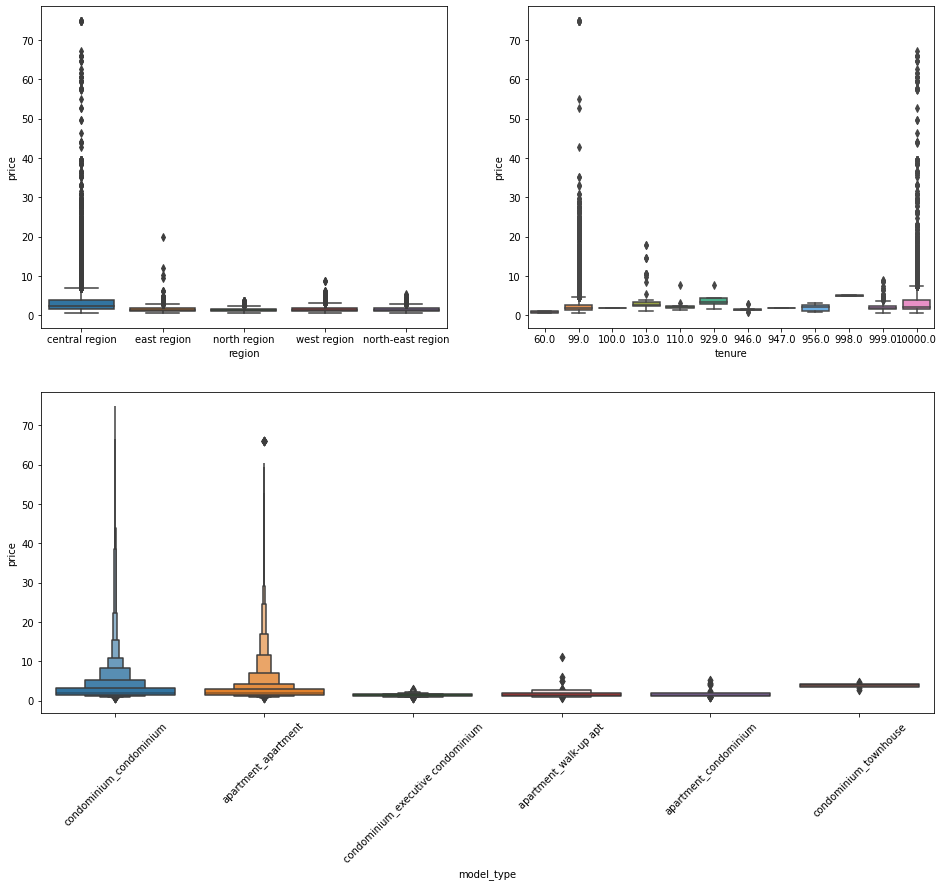

In [36]:
plt.figure(figsize=(16,13))

ax_1 = plt.subplot(2,2,1)
ax_2 = plt.subplot(2,2,2)
ax_3 = plt.subplot(2,1,2)
# ax_4 = plt.subplot(2,1,2)

sns.boxenplot(
    x='model_type', 
    y='price',  
    data=train_df,
    ax=ax_3
)

sns.boxplot(
    x="region", 
    y="price",  
    data=train_df,
    ax=ax_1
)

sns.boxplot(
    x='tenure',
    y='price',
    data=train_df,
    ax=ax_2

)
# sns.violinplot(
#     x="model", 
#     y="price",  
#     data=train_x,
#     ax=ax_4
# )

plt.xticks(rotation=45)
plt.show()

### Relationship between qualitative features and quantitative features

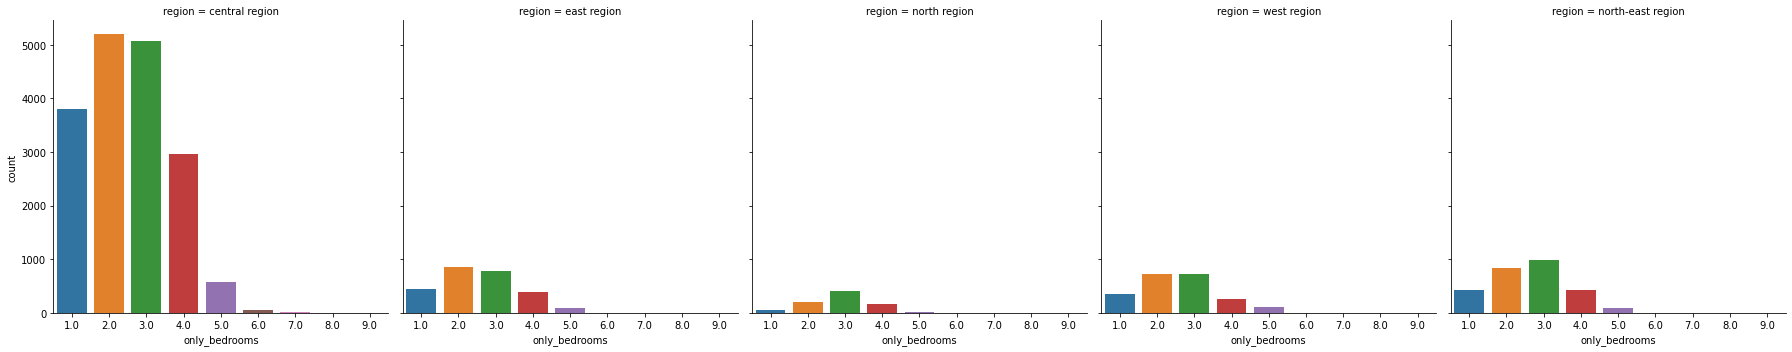

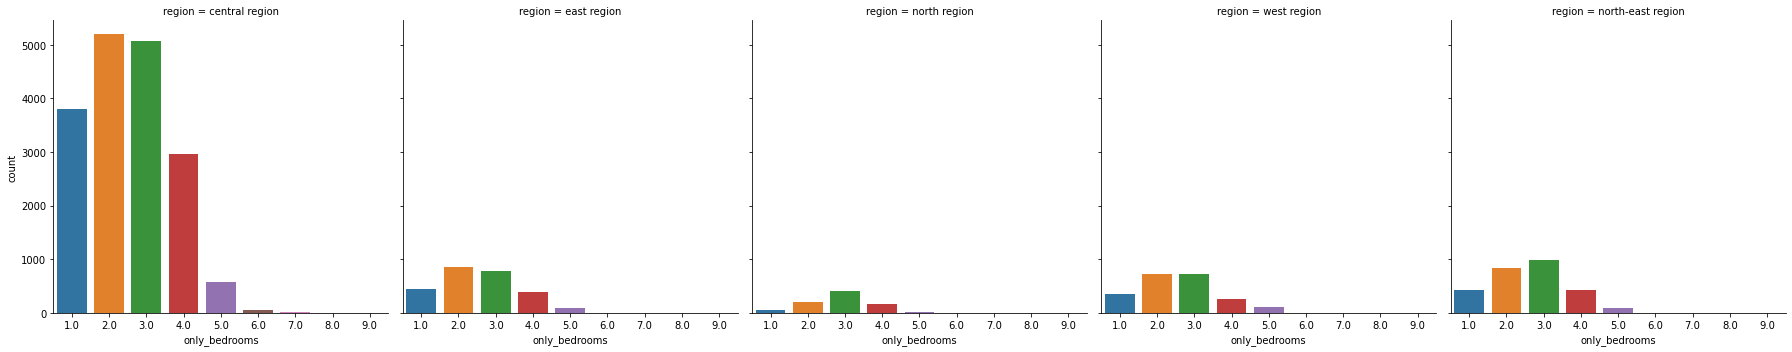

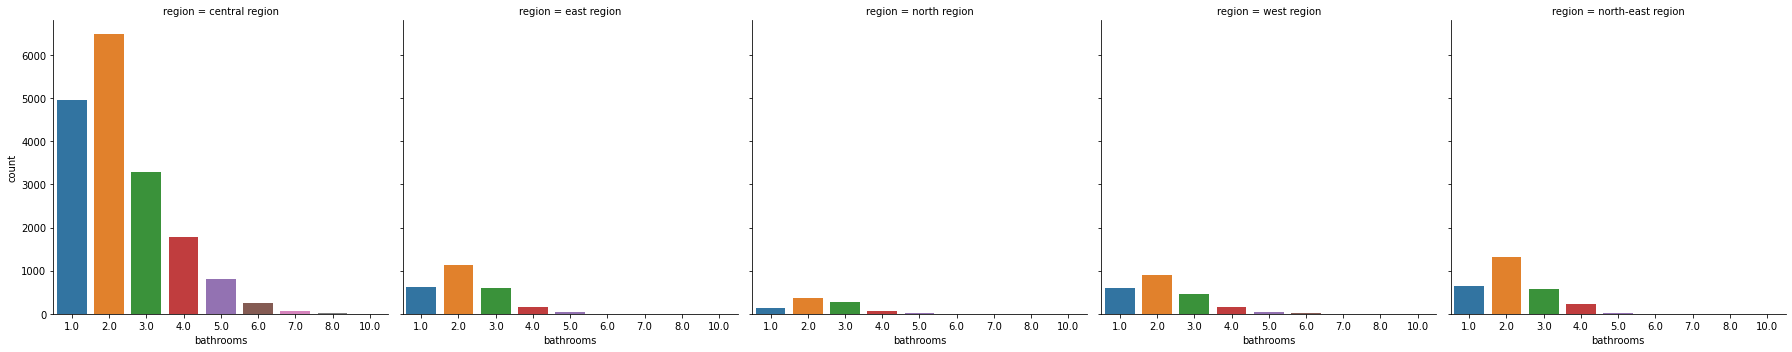

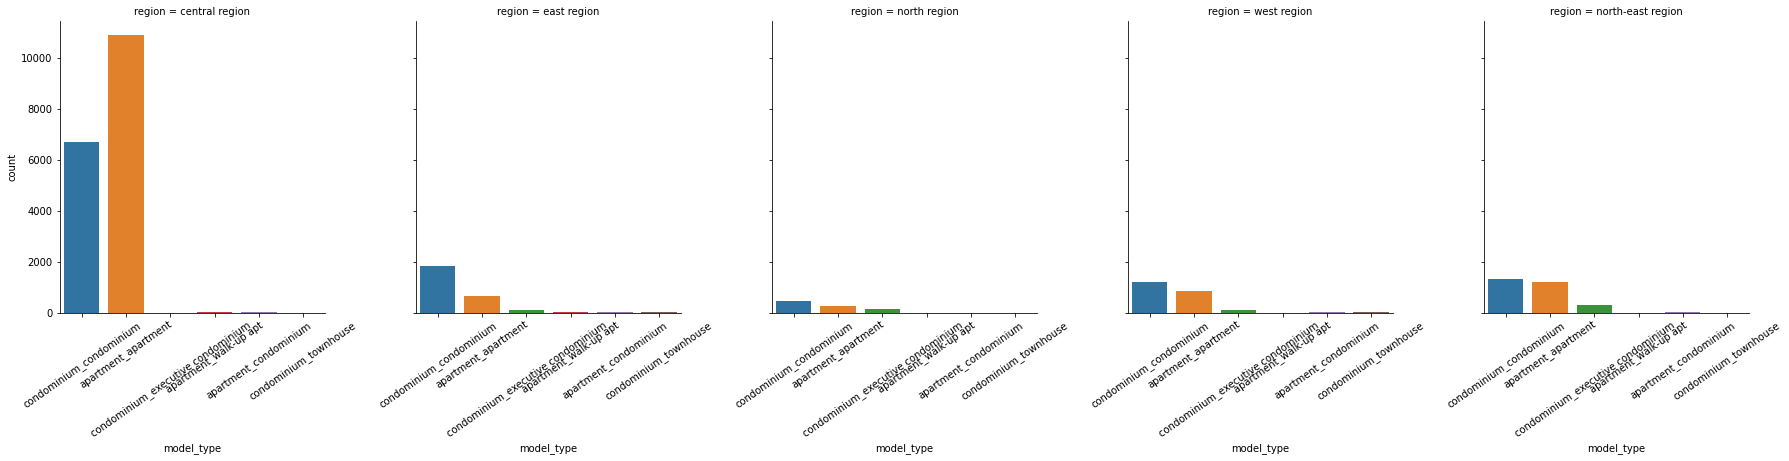

In [37]:
bed_region = sns.catplot(x="only_bedrooms", col="region",data=train_df,kind="count")
living_region = sns.catplot(x="only_bedrooms", col="region",data=train_df,kind="count")
bath_region = sns.catplot(x="bathrooms", col="region",data=train_df,kind="count")
model_type_region = sns.catplot(x="model_type", col="region",data=train_df,kind="count")

model_type_region.set_xticklabels(rotation=35)  

### Mine the correlations between location features

In [38]:
from pandas.api.types import is_string_dtype,is_numeric_dtype
import copy
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

qual_data = copy.deepcopy(train_df)
for i in qual_data.columns:
    if is_string_dtype(qual_data[i]):
#         x_train=x_train.join(pd.get_dummies(x_train[i],prefix=i))
        qual_data[i]=le.fit_transform(qual_data[i])

               street_name    region  planning_area  subszone
street_name       1.000000 -0.003846       0.046172  0.133751
region           -0.003846  1.000000      -0.075688  0.150005
planning_area     0.046172 -0.075688       1.000000  0.372100
subszone          0.133751  0.150005       0.372100  1.000000


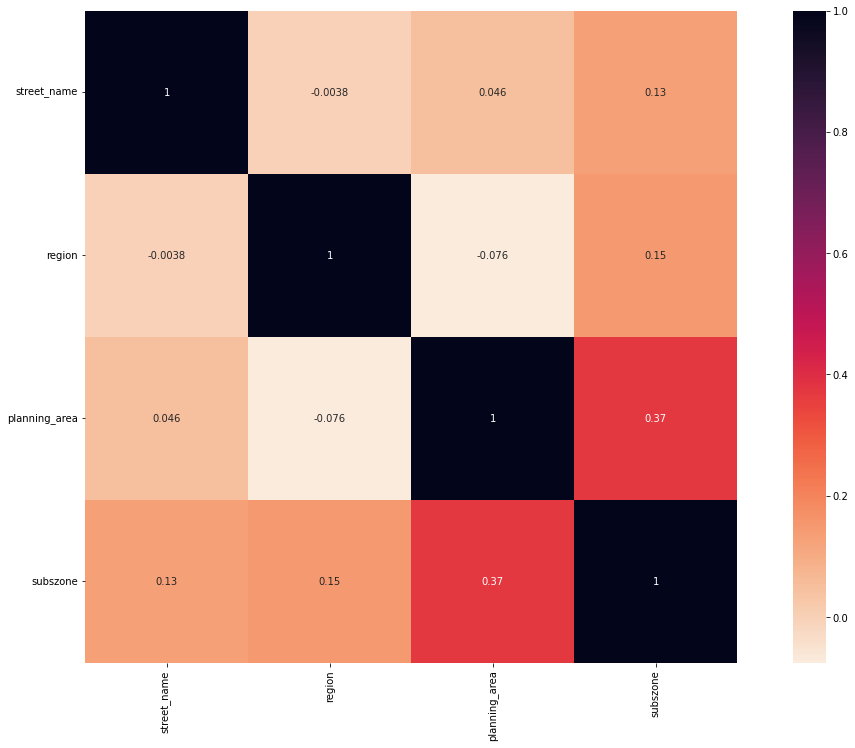

In [39]:
cmap = sns.cm.rocket_r
location_feature = ['street_name','region','planning_area','subszone']
train_corr = qual_data[location_feature].corr()
print(train_corr)
a = plt.subplots(figsize = (20,12))
a=sns.heatmap(train_corr,annot=True,cmap=cmap,square=True)
a.set_yticklabels(a.get_yticklabels(), rotation=360)
a.set_xticklabels(train_corr.index, rotation='vertical')
plt.show()

# 